# Financial Inclusion in Africa Notebook


This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing
- Creating a simple model
- Making a submissione

### Importing libraries

In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.metrics import accuracy_score, classification_report,plot_confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

#preprocessing module
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split ,StratifiedKFold,GridSearchCV
from imblearn.combine import SMOTEENN


##feature Scaling
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

###  Load the dataset

In [2]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

###  Data Assessing and cleaning

In [3]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', test.shape)

train data shape : (23524, 13)
test data shape : (10086, 12)


In [4]:
# inspect train data
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [5]:
# inspect data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


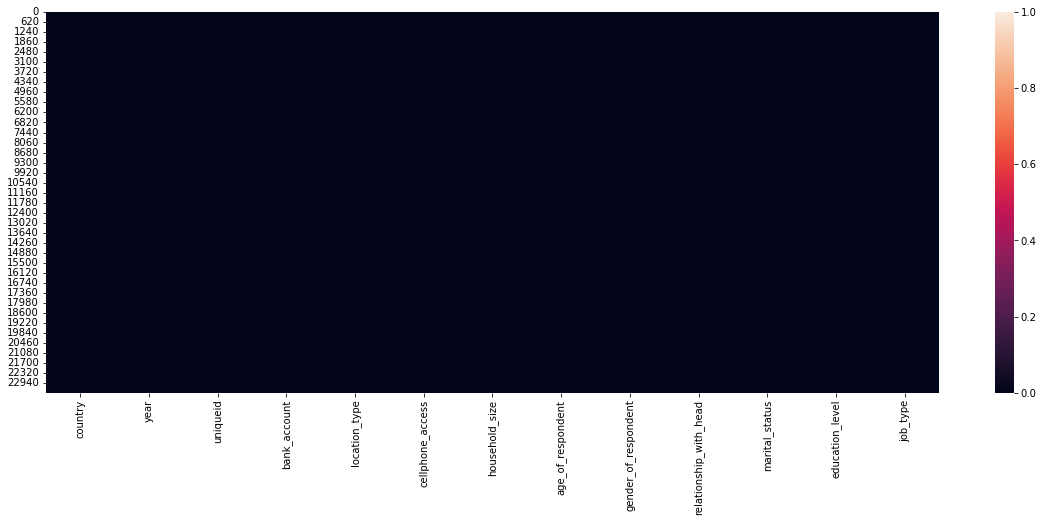

In [6]:
#check missing values
fig, ax = plt.subplots(figsize = (20,7))
ax = sns.heatmap(train.isnull(), vmin=0, vmax = 1)

- there seems to be no missing data

## Exploratory Data Analysis

In [7]:
train.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


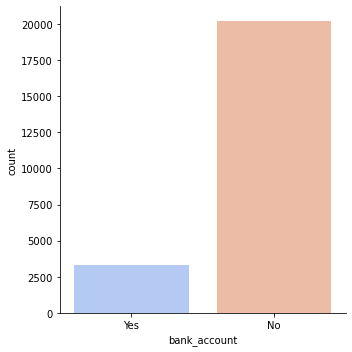

In [8]:
# Explore Target distribution 
sns.catplot(x="bank_account", kind="count", data=train,palette='coolwarm')

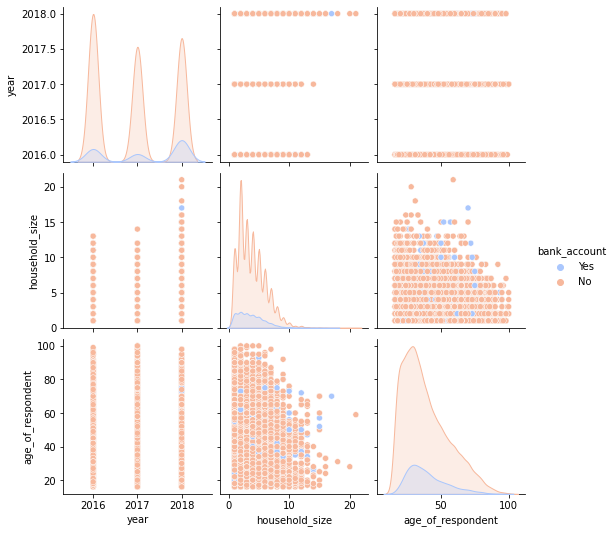

In [9]:
sns.pairplot(train,hue='bank_account',palette='coolwarm')

##  Feature Engineering And Data preprocessing

In [10]:
train["bank_account"].replace( { 'Yes':1, 'No':0} , inplace=True)

#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

In [11]:
# function to preprocess our data from train models
def preprocess_data(data):

    
    # categorical features to be onverted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]
    
    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    

    #Encoding categorical Data
    data['location_type'].replace( { 'Rural':0, 'Urban':1} , inplace=True)
    data['cellphone_access'].replace( { 'No':0, 'Yes':1} , inplace=True)
    data['gender_of_respondent'].replace( { 'Female':0, 'Male':1} , inplace=True) 
    
    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)
    
    # scale our data into range of 0 and 1
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    return data                  

In [12]:
# preprocess the train data 
processed_train = preprocess_data(X_train)
processed_test = preprocess_data(test)

In [13]:
#resampling the dataset 

sm= SMOTEENN(random_state=101)

In [14]:
X_res_train,y_res_train=sm.fit_resample(processed_train,y_train)

## model training and hyperparameter tuning

In [15]:
# Split train_data
from sklearn.model_selection import train_test_split

X_Train, X_Val, y_Train, y_val = train_test_split(X_res_train, y_res_train, stratify = y_res_train, 
                                                  test_size = 0.1, random_state=42)

In [16]:
xg_model = XGBClassifier()

In [17]:
# Optimize model parameters
param_grid = {'min_child_weighth': [1, 5, 10],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5]
        }
model = GridSearchCV(xg_model, param_grid,n_jobs=-1,verbose=2,cv=5)

In [18]:
model.fit(X_Train,y_Train)
print(model.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[21:29:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_child_weighth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


{'gamma': 1, 'max_depth': 5, 'min_child_weighth': 1, 'subsample': 1.0}


In [19]:
# Get the predicted result for the test Data

y_pred = model.predict(X_Val)

## model evaluation

In [20]:
# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_val, y_pred))

Error rate of XGB classifier:  0.030722484807562456


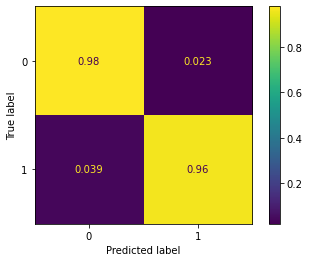

In [21]:
# Get confusion matrix for Gradient Boosting Classifier
plot_confusion_matrix(model,X_Val, y_val,normalize='true')

In [22]:
# Get the predicted result for the test Data
test.bank_account = model.predict(processed_test)

In [23]:
# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})

In [24]:
#show the five sample
submission.sample(5)

,uniqueid,bank_account
8489,uniqueid_8764 x Tanzania,1
4220,uniqueid_10355 x Rwanda,1
76,uniqueid_6145 x Kenya,1
5945,uniqueid_12080 x Rwanda,1
7740,uniqueid_8015 x Tanzania,1


In [25]:
# Create submission csv file csv file
submission.to_csv('first_submission.csv', index = False)